# Project Requirement 4: Algorithm Comparison

This notebook demonstrates the implementation of Project Requirement 4 using specialized seller classes:

- Multiple products + best-of-both-worlds + Primal-Dual

Both algorithms use the project-compliant binary demand model and corrected reward calculations.

In [17]:
# Import required libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from base_classes.setting import Setting
from base_classes.environment import Environment
from base_classes.specialized_sellers import create_seller_for_requirement
from plotting import plot_environment_results

# Set random seed for reproducible results
np.random.seed(42)

print("📚 Libraries imported and environment configured")
print("🎯 Ready to run Project Requirement 4")

📚 Libraries imported and environment configured
🎯 Ready to run Project Requirement 4


**Configuration:**
- Multiple products (N=10)
- Best-of-both-worlds: highly non-stationary environment
- PrimalDualSeller with inventory constraint
- Handles both stationary and adversarial settings

In [18]:
print("🏗️  REQUIREMENT 4: MULTIPLE PRODUCTS + PRIMAL-DUAL")
print("-" * 50)

setting = Setting(
    T=1000,
    n_products=10,  # Single product as required
    epsilon=0.1,   # Discrete price set (5 levels)
    distribution='gaussian',  # Stochastic base
    dist_params=(50, 15),
    verbose='no',
    non_stationary='highly',  # Highly non-stationary environment
    algorithm="primal_dual"
)

# Create environment with specialized seller
env = Environment(setting)


🏗️  REQUIREMENT 4: MULTIPLE PRODUCTS + PRIMAL-DUAL
--------------------------------------------------


In [19]:
env.seller = create_seller_for_requirement(3, setting)

print(f"Configuration:")
print(f"  - Products: {setting.n_products} (single product)")
print(f"  - Price levels: {int(1/setting.epsilon)}")
print(f"  - Environment: Highly non-stationary")
print(f"  - Seller: {env.seller.__class__.__name__}")
print(f"  - Budget constraint: {setting.B:.2f}")

# Run experiment
print(f"\n🚀 Running Requirement 3 experiment...")
env.play_all_rounds()

# Calculate results
req3_rewards = np.array(env.seller.history_rewards)
req3_regrets = env.optimal_rewards - req3_rewards
req3_cum_regret = np.cumsum(req3_regrets)

print(f"✅ Requirement 4 completed!")
print(f"   Final cumulative regret: {req3_cum_regret[-1]:.2f}")
print(f"   Total rewards: {np.sum(req3_rewards):.2f}")
print(f"   Efficiency: {(np.sum(req3_rewards)/np.sum(env.optimal_rewards)*100):.1f}%")

Configuration:
  - Products: 10 (single product)
  - Price levels: 10
  - Environment: Highly non-stationary
  - Seller: PrimalDualSeller
  - Budget constraint: 27.50

🚀 Running Requirement 3 experiment...
✅ Requirement 4 completed!
   Final cumulative regret: 3101.80
   Total rewards: 1557.40
   Efficiency: 33.4%


/Users/frain/Documents/GitHub/ola-proj-2425/project_work/plotting.py:255: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 1].legend()


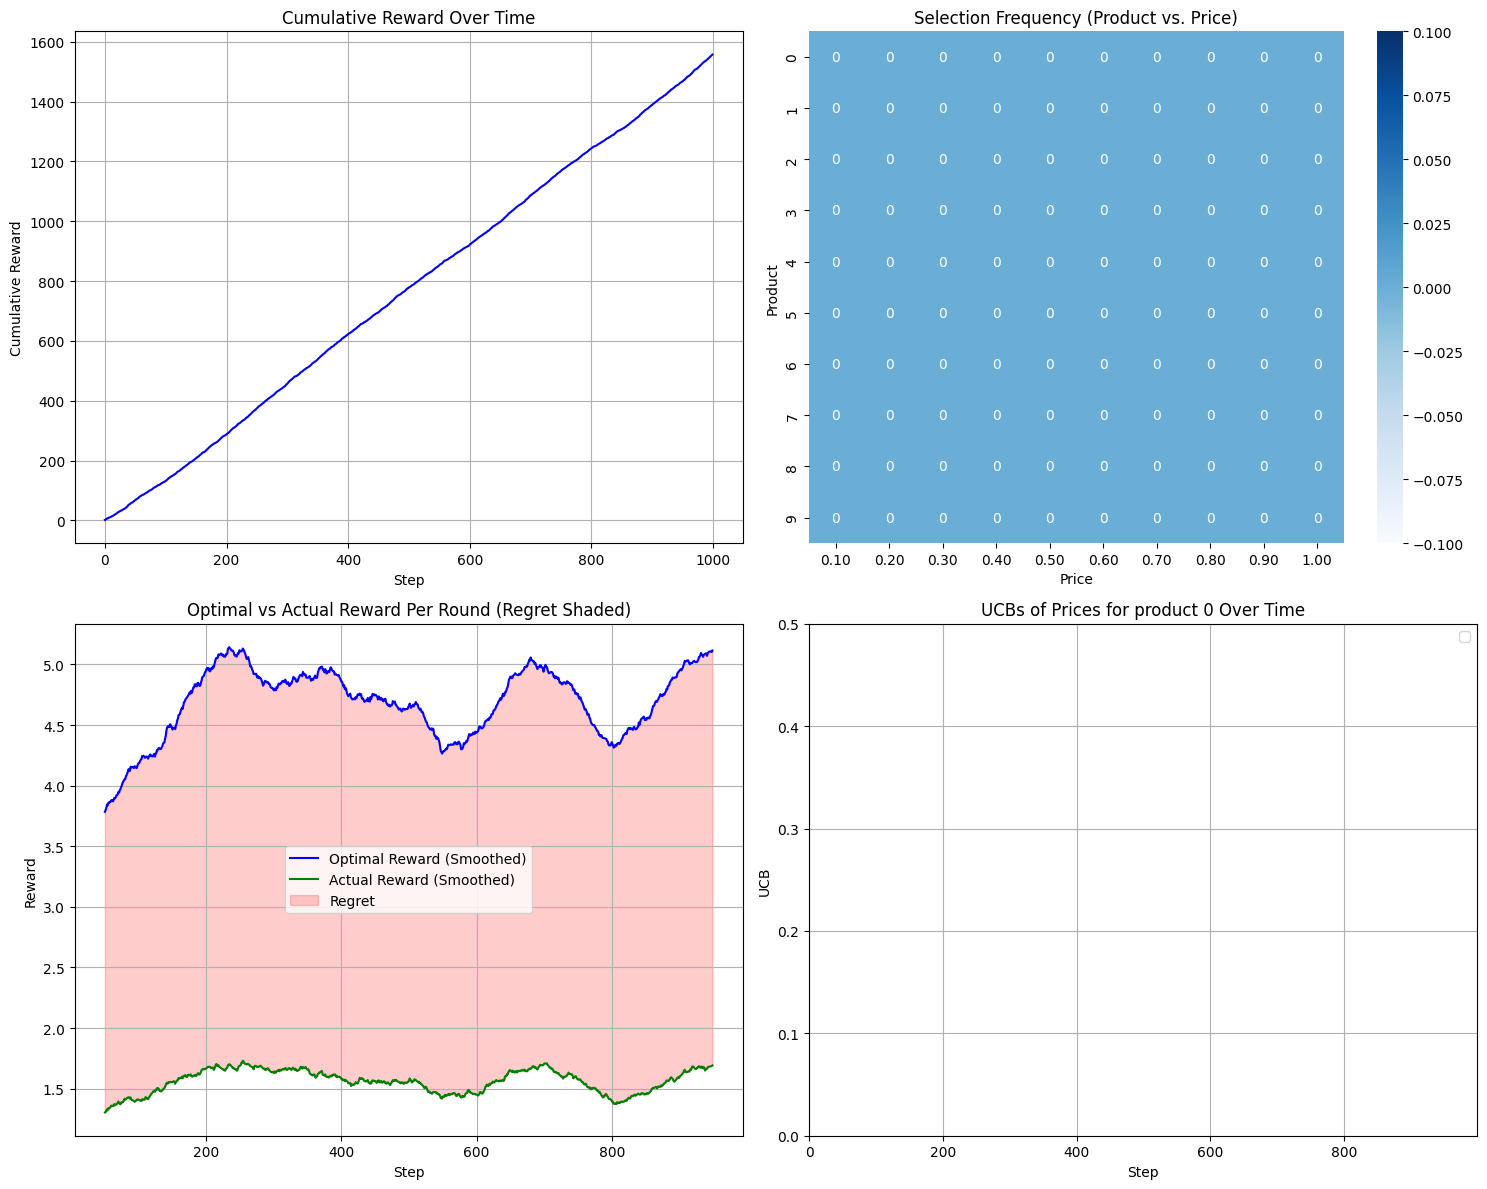

In [20]:
plot_environment_results(env)